# Object-oriented swath profile

In last two sections we have presented using PyOSP to perform traditional fixed- width/radius analysis. Here, we give case studies to introduce proposed methods in PyOSP that can objectively characterize geological structures having complex boundaries and orientations.

The basic concept is to combine the geo-classification with the swath analysis so that the landform information can be assimilated into the evaluation process. To target the specific topographic feature, PyOSP evaluates the geo-parameter values (e.g., elevation, slope, or topographic position index (TPI)) along the profile line, and truncates the current line development if pixel values exceed user-defined thresholds, or maximum allowed swath width is reached. The process is iterated along the baseline path according to the *line_stepsize*, which enables PyOSP to collect data from non-linear profiles with irregular boundaries. Figure below illustrates comparison between traditional (a) and proposed method (b) from data matrix perspective (min_value=10).

<img alt="homo_case" src="https://i.imgur.com/ufPQW40.jpg" height="250"/>

We use "object-oriented" to name the swath method as the key element here is to objectively define a topographic object through geo-parameter characteriation, which is in contast with previous "functional" approach that is largely parameterized through a fixed- width/radius. The comparison between these two is through the syntheric tests as given below.

For curvilinear swath analysis, we use an artifacial DEM dataset that was used in the first section.

<img alt="homo_case" src="https://i.imgur.com/nSFSqxo.png" height="250"/>

PyOSP offers elevation, slope, and topographic postion index (TPI) based swath methods in both cuvilinear (curvsp) and circular (cirsp) modules. Below gives a simple example for carrying out these geo-parameter aided analyses in curvilinear case.   

In [38]:
import pyosp

baseline = pyosp.datasets.get_path("homo_baseline.shp") # the path to baseline shapefile
raster = pyosp.datasets.get_path("homo_mount.tif")  # the path to raster file

fixed_width = pyosp.Orig_curv(baseline, raster, width=100,
                       line_stepsize=3, cross_stepsize=None)

elev = pyosp.Elev_curv(baseline, raster, width=100,
                       min_elev=0.01,
                       line_stepsize=3, cross_stepsize=None)

slope = pyosp.Slope_curv(baseline, raster, width=100,
                         min_slope=1,
                         line_stepsize=3, cross_stepsize=None)

tpi = pyosp.Tpi_curv(baseline, raster, width=100,
                     tpi_radius=50, min_tpi=0,
                     line_stepsize=3, cross_stepsize=None)

Processing: [#########################] 71 of 71 lineSteps

The code block above generated four swath objects corresponding to original (fixed-width), elevation, slope, and TPI methods, respectively. The default miminum and maximum value thresolds for elevation method are -inf and inf, for slope are 0 and 90, for TPI are -inf are inf. The *line_stepsize* and *cross_stepsize* equal to raster resolution by default. TPI based method has an additional parameter *tpi_radius* that controls the size of calculation window. For more information, users are refer to [Weiss, 2001] (http://www.jennessent.com/downloads/tpi-poster-tnc_18x22.pdf).

## Swath areas comparison

In previous section, we have shown the cases of using GDAL to plot the swath polygon on top of raster dataset. Here, we give an example by making use of [rasterio] (https://rasterio.readthedocs.io/en/latest/intro.html) to easily generate similar results. Note that PyOSP is not depend on rasterio, so the user needs to [install] (https://rasterio.readthedocs.io/en/latest/installation.html) it seperately.

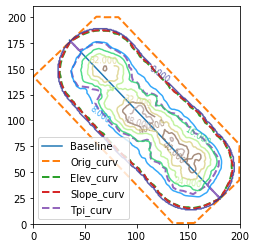

In [39]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# plot the shapely object
def plot_coords(ax, ob, **kwargs):
    x, y = ob.xy
    ax.plot(x, y, zorder=1, **kwargs)

src = rasterio.open(raster)
swath_obs = [fixed_width, elev, slope, tpi]
line_shape = pyosp.read_shape(baseline)

fig, ax = plt.subplots()
show(src.read(), transform=src.transform, ax=ax, contour=True, cmap='terrain')
plot_coords(ax=ax, ob=line_shape, label="Baseline")

for ob in swath_obs:
    plot_coords(ax=ax, ob=ob.out_polygon().exterior, 
                linestyle="--", lw=2, label=str(ob))

ax.set_aspect('equal', adjustable='box')
ax.legend()

As shown above, both elevation and slope based methods captured the exact shape of mountain object. This is achieved by setting the small minimum threshold of 0.01m and 1 degree that seperated mountain range and flat ground. The TPI swath goes with elevation=16m for a great portion, which essentially delineates the convex up (erosional) slopes from the convex down (depositional slopes) in the topography, offering some interesting insights about the topoghraphic development.